In [ ]:
# Mount into drive

from google.colab import drive

drive.mount("/content/drive")

%cd '/content/drive/MyDrive/Group Project/'

!pip install -r requirements.txt
# Upgrade TensorFlow
!pip install --upgrade tensorflow
!pip install --upgrade jax jaxlib

Mounted at /content/drive
/content/drive/MyDrive/Group Project
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=c97dd8f711161e98579b3c4498080e7e28f49ccb37fb1693472e566712974940
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 82.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are

In [ ]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit"
os.environ.pop("XLA_FLAGS", None)
import json
import requests
from PIL import Image
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch
import torch.nn as nn
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import ParameterGrid
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import numpy as np
import spacy
from typing import Dict, List, Tuple, Optional, Union
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate.nist_score import sentence_nist
from nltk.translate.ribes_score import sentence_ribes
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams
import editdistance
from collections import Counter
from transformers import CLIPProcessor, CLIPModel, BlipProcessor, BlipForConditionalGeneration
from torch.utils.data.distributed import DistributedSampler

print("PyTorch version:", torch.__version__)
print("NumPy version:", np.__version__)
print("SpaCy version:", spacy.__version__)

nlp = spacy.load('en_core_web_sm')
print("SpaCy model loaded successfully!")
print("\nAll dependencies installed and verified!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


PyTorch version: 2.5.1+cu121
NumPy version: 1.26.4
SpaCy version: 3.7.5
SpaCy model loaded successfully!

All dependencies installed and verified!


In [ ]:
print(torch.__version__)
print(torch.version.cuda)

2.5.1+cu121
12.1


In [ ]:
if torch.cuda.is_available():
    print(f"CUDA is available. GPU being used: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU instead.")

CUDA is available. GPU being used: Tesla T4


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## DataSet

In [ ]:
flickr8k_img_dir = "Data/Flickr8k/Images"
flickr8k_ann_file = "Data/Flickr8k/Flickr8k.token.txt"
flickr8k_train_split = "Data/Flickr8k/Flickr8k.trainImages.txt"
flickr8k_val_split = "Data/Flickr8k/Flickr8k.devImages.txt"

# NoCaps
nocaps_val_dir = "Data/NoCap/validation_images"
nocaps_test_dir = "Data/NoCap/test_images"
nocaps_val_ann = "Data/NoCap/Validation_Set.json"
nocaps_test_ann = "Data/NoCap/Test_Set.json"

In [ ]:
def load_flickr8k_annotations(annotation_file, split_file, image_dir):
    with open(split_file, "r") as f:
        split_images = set(f.read().splitlines())

    annotations = []
    with open(annotation_file, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            img_id, caption = parts[0].split("#")[0], parts[1]

            if img_id in split_images:
                annotations.append({"image_id": img_id, "caption": caption})

    return annotations


In [ ]:
def load_nocap_annotations(annotation_file, image_dir):
    with open(annotation_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    annotations = [
        {
            "image_id": img["file_name"],
            "caption": ann.get("caption", "No caption available"),
        }
        for img, ann in zip(data["images"], data["annotations"])
    ]
    return annotations

# Split NoCap dataset into train, validation, and test
def split_nocap_dataset(annotations, val_size=0.2, test_size=0.2):
    train_data, temp_data = train_test_split(annotations, test_size=(val_size + test_size), random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=(test_size / (val_size + test_size)), random_state=42)
    return train_data, val_data, test_data

In [ ]:
class UnifiedDataset(Dataset):
    def __init__(self, annotations, image_dir, clip_transform=None, blip_transform=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.clip_transform = clip_transform
        self.blip_transform = blip_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_path = os.path.join(self.image_dir, ann["file_name"])
        caption = ann.get("caption", "No caption available")

        image = Image.open(img_path).convert("RGB")
        clip_image = self.clip_transform(image) if self.clip_transform else image
        blip_image = self.blip_transform(image) if self.blip_transform else image

        return clip_image, blip_image, caption

In [ ]:
# Configure DataLoader
def configure_dataloader(dataset, batch_size=32):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())

In [ ]:
clip_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to CLIP's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])  # CLIP normalization
])

blip_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to BLIP's input size
    transforms.ToTensor(),  # No normalization; BLIP handles this internally
])

In [ ]:
# Load Flickr8k annotations
def load_flickr8k_annotations(annotation_file, split_file, image_dir):
    """
    Load Flickr8k annotations and match captions with the specified split file.
    """
    # Read the split file to get the image IDs
    with open(split_file, "r") as f:
        split_images = set(f.read().splitlines())

    # Read captions from the annotation file
    annotations = []
    with open(annotation_file, "r") as f:
        for line in f:
            img_caption = line.strip().split("\t")
            img_id, caption = img_caption[0].split("#")[0], img_caption[1]

            if img_id in split_images:
                annotations.append({"file_name": img_id, "caption": caption})

    return annotations


# Define paths for Flickr8k
flickr8k_img_dir = "Data/Flickr8k/Images"
flickr8k_ann_file = "Data/Flickr8k/Flickr8k.token.txt"
flickr8k_train_split = "Data/Flickr8k/Flickr_8k.trainImages.txt"
flickr8k_val_split = "Data/Flickr8k/Flickr_8k.devImages.txt"
flickr8k_test_split = "Data/Flickr8k/Flickr_8k.testImages.txt"

# Load Flickr8k datasets
flickr8k_train_ann = load_flickr8k_annotations(flickr8k_ann_file, flickr8k_train_split, flickr8k_img_dir)
flickr8k_val_ann = load_flickr8k_annotations(flickr8k_ann_file, flickr8k_val_split, flickr8k_img_dir)
flickr8k_test_ann = load_flickr8k_annotations(flickr8k_ann_file, flickr8k_test_split, flickr8k_img_dir)

flickr8k_train_dataset = UnifiedDataset(flickr8k_train_ann, flickr8k_img_dir, clip_transform, blip_transform)
flickr8k_val_dataset = UnifiedDataset(flickr8k_val_ann, flickr8k_img_dir, clip_transform, blip_transform)
flickr8k_test_dataset = UnifiedDataset(flickr8k_test_ann, flickr8k_img_dir, clip_transform, blip_transform)

flickr8k_train_loader = configure_dataloader(flickr8k_train_dataset, batch_size=32)
flickr8k_val_loader = configure_dataloader(flickr8k_val_dataset, batch_size=32)
flickr8k_test_loader = configure_dataloader(flickr8k_test_dataset, batch_size=32)

In [ ]:
# Define paths for NoCap
nocaps_val_dir = "Data/NoCap/validation_images"
nocaps_test_dir = "Data/NoCap/test_images"
nocaps_val_ann = "Data/NoCap/Validation_Set.json"
nocaps_test_ann = "Data/NoCap/Test_Set.json"

# Load and split NoCap dataset
with open(nocaps_val_ann, encoding="utf-8") as f:
    nocaps_val_data = json.load(f)

val_images = nocaps_val_data["images"]
annotations = nocaps_val_data["annotations"]

# Link image IDs to annotations
image_to_caption = {ann["image_id"]: ann for ann in annotations}
for img in val_images:
    img["caption"] = image_to_caption.get(img["id"], {}).get("caption", "No caption available")

# Split NoCap validation set into train and validation
train_images, val_images_split = train_test_split(val_images, test_size=0.2, random_state=42)

nocaps_train_dataset = UnifiedDataset(train_images, nocaps_val_dir, clip_transform, blip_transform)
nocaps_val_dataset = UnifiedDataset(val_images_split, nocaps_val_dir, clip_transform, blip_transform)

# Load NoCap test set
with open(nocaps_test_ann, encoding="utf-8") as f:
    nocaps_test_data = json.load(f)

nocaps_test_dataset = UnifiedDataset(nocaps_test_data["images"], nocaps_test_dir, clip_transform, blip_transform)

nocaps_train_loader = configure_dataloader(nocaps_train_dataset, batch_size=32)
nocaps_val_loader = configure_dataloader(nocaps_val_dataset, batch_size=32)
nocaps_test_loader = configure_dataloader(nocaps_test_dataset, batch_size=32)

Load CLIP and BLIP Model

In [ ]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_processor.image_processor.do_rescale = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:

class ModelEvaluator:
    def __init__(self, device: str = 'cuda' if torch.cuda.is_available() else 'cpu', processor=None):

        self.device = device
        self.nlp = spacy.load('en_core_web_sm')
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        self.processor = processor

    def _tokenize(self, text: Union[str, List[str]]) -> List[str]:

        if isinstance(text, str):
            return word_tokenize(text.lower())
        return text

    def compute_accuracy(self, predictions: torch.Tensor, targets: torch.Tensor) -> float:

        if predictions.dim() > 1:
            predictions = predictions.argmax(dim=1)
        return accuracy_score(targets.cpu(), predictions.cpu())

    def compute_precision_recall_f1(self, predictions: torch.Tensor,
                                  targets: torch.Tensor,
                                  average: str = 'weighted') -> Tuple[float, float, float]:

        if predictions.dim() > 1:
            predictions = predictions.argmax(dim=1)
        precision, recall, f1, _ = precision_recall_fscore_support(
            targets.cpu(), predictions.cpu(), average=average
        )
        return precision, recall, f1

    def compute_cross_entropy_loss(self, predictions: torch.Tensor,
                                 targets: torch.Tensor,
                                 reduction: str = 'mean') -> float:

        loss_fn = nn.CrossEntropyLoss(reduction=reduction)
        return loss_fn(predictions, targets).item()

    def compute_auc_roc(self, predictions: torch.Tensor,
                       targets: torch.Tensor,
                       multi_class: str = 'ovr') -> float:

        if predictions.dim() == 1:
            predictions = F.softmax(predictions.unsqueeze(1), dim=1)
        else:
            predictions = F.softmax(predictions, dim=1)
        return roc_auc_score(targets.cpu(), predictions.cpu(), multi_class=multi_class)

    def compute_map(self, predictions: torch.Tensor, targets: torch.Tensor) -> float:

        if predictions.dim() == 1:
            predictions = predictions.unsqueeze(1)
        return average_precision_score(targets.cpu(), predictions.cpu())

    def compute_inference_time(self, model: nn.Module,
                             input_data: Union[torch.Tensor, Tuple[torch.Tensor, ...]],
                             num_runs: int = 100) -> Dict[str, float]:

        model.eval()
        model.to(self.device)

        if isinstance(input_data, tuple):
            input_data = tuple(x.to(self.device) for x in input_data)
        else:
            input_data = input_data.to(self.device)

        times = []
        with torch.no_grad():
            for _ in range(num_runs):
                start_time = time.time()
                _ = model(input_data)
                end_time = time.time()
                times.append(end_time - start_time)

        return {
            'mean_time': np.mean(times),
            'std_time': np.std(times),
            'min_time': np.min(times),
            'max_time': np.max(times)
        }

    def compute_confusion_matrix(self, predictions: torch.Tensor,
                               targets: torch.Tensor) -> np.ndarray:

        if predictions.dim() > 1:
            predictions = predictions.argmax(dim=1)
        return confusion_matrix(targets.cpu(), predictions.cpu())

    def compute_bleu(self, candidates, references, weights=(0.25, 0.25, 0.25, 0.25)):
      """
      Compute BLEU
      """
      #references = [ref for ref in references]
      # smoothing = SmoothingFunction().method1
      return corpus_bleu(references, candidates, weights=weights)


    def compute_meteor(self, candidate: Union[str, List[str]], references: Union[List[str], List[List[str]]]) -> float:
        """
        Compute METEOR
        """
        try:
            # Tokenize candidate and references
            candidate_tokens = self._tokenize(candidate)
            reference_tokens = [self._tokenize(ref) for ref in references]

            score = meteor_score(reference_tokens, candidate_tokens)
            return score
        except Exception as e:
            print(f"METEOR computation failed: {e}")
            return 0.0

    def compute_rouge(self, candidate: Union[str, List[str]], reference: Union[str, List[str]]) -> Dict[str, float]:
        """
        Compute ROUGE
        """
        try:
            # Convert to strings for RougeScorer
            candidate_str = ' '.join(self._tokenize(candidate))
            reference_str = ' '.join(self._tokenize(reference))

            scores = self.rouge_scorer.score(reference_str, candidate_str)
            return {
                'rouge1': scores['rouge1'].fmeasure,
                'rouge2': scores['rouge2'].fmeasure,
                'rougeL': scores['rougeL'].fmeasure
            }
        except Exception as e:
            print(f"ROUGE computation failed: {e}")
            return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

    def compute_cider(self, candidate: Union[str, List[str]], references: Union[List[str], List[List[str]]]) -> float:
      """
      Compute CIDEr
      """
      try:
          # Tokenize candidate and references
          candidate_tokens = self._tokenize(candidate)
          reference_tokens = [self._tokenize(ref) for ref in references]

          print("Candidate Tokens:", candidate_tokens)
          print("Reference Tokens:", reference_tokens)

          if not candidate_tokens or not any(reference_tokens):
              print("Empty tokenized inputs. Returning 0.")
              return 0.0

          candidate_ngrams = [' '.join(gram) for n in range(1, 5) for gram in ngrams(candidate_tokens, n)]
          reference_ngrams = [[' '.join(gram) for n in range(1, 5) for gram in ngrams(ref_tokens, n)] for ref_tokens in reference_tokens]

          flattened_reference_ngrams = [ngram for ref_ngrams in reference_ngrams for ngram in ref_ngrams]

          all_ngrams = candidate_ngrams + flattened_reference_ngrams
          tfidf = TfidfVectorizer(ngram_range=(1, 4)).fit_transform(all_ngrams)

          candidate_tfidf = tfidf[0].toarray()[0]
          reference_tfidf = tfidf[1:].toarray()

          print("Candidate TF-IDF:", candidate_tfidf)
          print("Reference TF-IDF:", reference_tfidf)

          similarities = []
          for ref_tfidf in reference_tfidf:
              norm_candidate = np.linalg.norm(candidate_tfidf)
              norm_reference = np.linalg.norm(ref_tfidf)

              if norm_candidate == 0 or norm_reference == 0:
                  similarities.append(0.0)
              else:
                  similarity = np.dot(candidate_tfidf, ref_tfidf) / (norm_candidate * norm_reference)
                  similarities.append(similarity)

          return 10 * np.mean(similarities) if similarities else 0.0

      except Exception as e:
          print(f"CIDEr computation failed: {e}")
          return 0.0

    def compute_spice(self, candidate: Union[str, List[str]], reference: Union[str, List[str]]) -> float:
        """
        Compute SPICE (Semantic Propositional Image Caption Evaluation) score.

        """
        try:
            # Tokenize candidate and reference
            candidate_tokens = self._tokenize(candidate)
            reference_tokens = self._tokenize(reference)

            candidate_props = self._extract_semantic_props(candidate_tokens)
            reference_props = self._extract_semantic_props(reference_tokens)

            if not candidate_props or not reference_props:
                return 0.0

            intersection = len(candidate_props & reference_props)
            precision = intersection / len(candidate_props) if candidate_props else 0
            recall = intersection / len(reference_props) if reference_props else 0

            if precision + recall == 0:
                return 0.0

            f_score = 2 * (precision * recall) / (precision + recall)
            return f_score

        except Exception as e:
            print(f"SPICE computation failed: {e}")
            return 0.0

    def _extract_semantic_props(self, tokens):
        """Extract semantic properties using spaCy"""
        doc = self.nlp(" ".join(tokens))
        props = set()

        for ent in doc.ents:
            props.add(ent.text.lower())

        for token in doc:
            if token.pos_ in ["NOUN", "ADJ", "VERB"]:
                props.add(token.text.lower())

        return props

    # Set padding side for the processor
    blip_processor.tokenizer.padding_side = "left"

    def evaluate_model(self, model, dataloader, metrics=None, processor=None):
      if metrics is None:
          metrics = ['bleu', 'meteor', 'rouge', 'cider', 'spice']

      model.eval()
      all_candidates = []
      all_references = []

      with torch.no_grad():
          for batch in tqdm(dataloader):
              clip_images, blip_images, captions = batch

              inputs = processor(images=blip_images, text=captions, return_tensors="pt", padding=True, truncation=True).to(self.device)
              outputs = model.generate(**inputs, max_new_tokens=50)
              predictions = processor.batch_decode(outputs, skip_special_tokens=True)

              all_candidates.extend(predictions)
              all_references.extend([[cap] for cap in captions])

      print("Candidates (Untokenized):", all_candidates[:5])
      print("References (Untokenized):", all_references[:5])

      results = self.evaluate_captions(all_candidates, all_references, metrics=metrics)

      return results

    def evaluate_captions(self, candidates: List[str], references: List[List[str]], metrics=None):
      if metrics is None:
          metrics = ['bleu', 'meteor', 'rouge', 'cider', 'spice']

      results = {}

      # Tokenize inputs for BLEU separately
      bleu_candidates = [candidate.lower().split() for candidate in candidates]
      bleu_references = [[ref.lower().split() for ref in refs] for refs in references]

      for metric in metrics:
          scores = []

          for candidate, refs in zip(candidates, references):
              if metric == 'bleu':
                  # Use tokenized inputs for BLEU
                  score = self.compute_bleu(bleu_candidates, bleu_references)
              elif metric == 'meteor':
                  # Use untokenized inputs for other metrics
                  score = self.compute_meteor(candidate, refs)
              elif metric == 'rouge':
                  score = self.compute_rouge(candidate, refs[0])
                  score = score['rouge1']
              elif metric == 'cider':
                  score = self.compute_cider(candidate, refs)
              elif metric == 'spice':
                  score = self.compute_spice(candidate, refs[0])

              scores.append(score)

          results[metric] = np.mean(scores)

      return results

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
class EvaluationVisualizer:
    def __init__(self, style: str = 'seaborn'):

        self.style = style
        plt.style.use('seaborn-v0_8-whitegrid')

    def plot_metric_comparison(self,
                             metrics_dict: Dict[str, List[float]],
                             model_names: List[str],
                             title: str = "Model Comparison",
                             figsize: tuple = (10, 6)) -> None:

        plt.figure(figsize=figsize)

        x = np.arange(len(model_names))
        width = 0.8 / len(metrics_dict)

        for i, (metric_name, values) in enumerate(metrics_dict.items()):
            plt.bar(x + i * width, values, width, label=metric_name)

        plt.xlabel('Models')
        plt.ylabel('Score')
        plt.title(title)
        plt.xticks(x + width * (len(metrics_dict) - 1) / 2, model_names, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_metric_history(self,
                          metric_history: Dict[str, List[float]],
                          title: str = "Metric History",
                          figsize: tuple = (10, 6)) -> None:

        plt.figure(figsize=figsize)

        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name, marker='o')

        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self,
                            conf_matrix: np.ndarray,
                            class_names: Optional[List[str]] = None,
                            title: str = "Confusion Matrix",
                            figsize: tuple = (8, 6)) -> None:

        plt.figure(figsize=figsize)

        if class_names is None:
            class_names = [f'Class {i}' for i in range(len(conf_matrix))]

        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names)

        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def plot_caption_metrics_radar(self,
                                 metrics: Dict[str, float],
                                 title: str = "Caption Quality Metrics",
                                 figsize: tuple = (10, 10)) -> None:

        if self.style == 'plotly':
            categories = list(metrics.keys())
            values = list(metrics.values())

            fig = go.Figure(data=[go.Scatterpolar(
                r=values + [values[0]],
                theta=categories + [categories[0]],
                fill='toself'
            )])

            fig.update_layout(
                polar=dict(
                    radialaxis=dict(
                        visible=True,
                        range=[0, max(values) * 1.2]
                    )),
                showlegend=False,
                title=title
            )
            fig.show()
        else:
            # Matplotlib version
            categories = list(metrics.keys())
            values = list(metrics.values())

            angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
            values = np.concatenate((values, [values[0]]))
            angles = np.concatenate((angles, [angles[0]]))

            fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
            ax.plot(angles, values)
            ax.fill(angles, values, alpha=0.25)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(categories)
            plt.title(title)
            plt.show()

    def plot_caption_length_distribution(self,
                                      captions: List[str],
                                      title: str = "Caption Length Distribution",
                                      figsize: tuple = (10, 6)) -> None:

        lengths = [len(caption.split()) for caption in captions]

        plt.figure(figsize=figsize)
        sns.histplot(lengths, bins=30, kde=True)
        plt.xlabel('Number of Words')
        plt.ylabel('Frequency')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def plot_metric_correlation(self,
                              metrics_data: Dict[str, List[float]],
                              title: str = "Metric Correlations",
                              figsize: tuple = (10, 8)) -> None:

        df = pd.DataFrame(metrics_data)
        correlation_matrix = df.corr()

        plt.figure(figsize=figsize)
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def plot_interactive_caption_comparison(self,
                                         candidates: List[str],
                                         references: List[List[str]],
                                         metrics: Dict[str, List[float]],
                                         title: str = "Caption Comparison") -> None:

        if self.style != 'plotly':
            print("This visualization requires plotly style.")
            return

        fig = make_subplots(rows=2, cols=1,
                           subplot_titles=("Metric Scores", "Caption Text"),
                           row_heights=[0.7, 0.3])

        # Add metrics visualization
        for metric_name, values in metrics.items():
            fig.add_trace(
                go.Bar(name=metric_name, x=list(range(len(values))), y=values),
                row=1, col=1
            )

        # Add caption text
        caption_text = []
        for i, (cand, refs) in enumerate(zip(candidates, references)):
            caption_text.append(f"Generated {i}: {cand}<br>References: {'; '.join(refs)}")

        fig.add_trace(
            go.Table(
                header=dict(values=["Captions"]),
                cells=dict(values=[caption_text])
            ),
            row=2, col=1
        )

        fig.update_layout(height=800, title_text=title)
        fig.show()

## Model Hyper-Param Tuning, Evaluation

In [ ]:
evaluator = ModelEvaluator(processor=blip_processor)
visualizer = EvaluationVisualizer()


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
def extract_clip_features(clip_images, model):
    with torch.no_grad():
        clip_features = model.get_image_features(clip_images)
    return clip_features


In [ ]:
# Hyperparameter Tuning
param_grid = {
    "lr": [0.001],
    "batch_size": [32],
    "epochs": [5]
}
grid = list(ParameterGrid(param_grid))

In [ ]:
def fine_tune_with_hyperparams(train_loader, val_loader, clip_model, blip_model, processor, params, evaluator):
    optimizer = torch.optim.AdamW(blip_model.parameters(), lr=params["lr"])
    train_losses, val_losses = [], []

    for epoch in range(params["epochs"]):
        blip_model.train()
        train_loss = 0

        for clip_images, blip_images, captions in tqdm(train_loader, desc=f"Epoch {epoch+1}/{params['epochs']}"):
            blip_inputs = processor(
                images=blip_images,
                text=captions,
                return_tensors="pt",
                padding=True,
                truncation=True,
            ).to(device)

            blip_inputs["labels"] = blip_inputs.input_ids.clone()

            # Forward pass
            outputs = blip_model(**blip_inputs)
            loss = outputs.loss

            if loss is None:
                raise ValueError("Loss is None. Check input format or labels.")

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation phase
        blip_model.eval()
        val_loss = 0
        with torch.no_grad():
            for clip_images, blip_images, captions in val_loader:
                blip_inputs = processor(
                    images=blip_images,
                    text=captions,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                ).to(device)

                blip_inputs["labels"] = blip_inputs.input_ids.clone()
                outputs = blip_model(**blip_inputs)
                val_loss += outputs.loss.item()

        val_losses.append(val_loss / len(val_loader))

    return train_losses, val_losses


In [ ]:
def hyperparameter_tuning(train_dataset, val_dataset, clip_model, blip_model, processor, param_grid, evaluator):
    best_params = None
    best_val_loss = float("inf")

    with tqdm(total=len(param_grid), desc="Hyperparameter Tuning") as pbar:
        for params in param_grid:
            print(f"Testing parameters: {params}")

            train_loader = configure_dataloader(train_dataset, batch_size=params["batch_size"])
            val_loader = configure_dataloader(val_dataset, batch_size=params["batch_size"])

            train_losses, val_losses = fine_tune_with_hyperparams(
                train_loader, val_loader, clip_model, blip_model, processor, params, evaluator
            )

            avg_val_loss = sum(val_losses) / len(val_losses)
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_params = params

            print(f"Validation Loss: {avg_val_loss:.4f}")
            pbar.update(1)

    print(f"Best Parameters: {best_params}, Best Validation Loss: {best_val_loss:.4f}")
    return best_params


In [ ]:
# Tune and train models for Flickr8k
flickr8k_params = hyperparameter_tuning(
    flickr8k_train_dataset, flickr8k_val_dataset, clip_model, blip_model, blip_processor, grid, evaluator
)

# # Tune and train models for NoCap
# nocap_params = hyperparameter_tuning(
#     nocaps_train_dataset, nocaps_val_dataset, clip_model, blip_model, blip_processor, grid, evaluator
# )


In [ ]:
params = {
    'batch_size': 32,
    'epochs': 3,
    'lr': 1e-5
}

blip_model_flickr8k = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
£blip_model_nocap = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Train Flickr8k model
fine_tune_with_hyperparams(
    flickr8k_train_loader,
    flickr8k_val_loader,
    clip_model,
    blip_model_flickr8k,
    blip_processor,
    params,
    evaluator
)

# # Train NoCap model
# fine_tune_with_hyperparams(
#     nocaps_train_loader,
#     nocaps_val_loader,
#     clip_model,
#     blip_model_nocap,
#     blip_processor,
#     params,
#     evaluator
# )


In [ ]:
torch.save(blip_model_flickr8k.state_dict(), "fine_tuned_flickr8k_model.pth")

In [ ]:
blip_model_flickr8k = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Load the saved weights
blip_model_flickr8k.load_state_dict(torch.load("fine_tuned_flickr8k_model.pth"))

# Put the model in evaluation mode
blip_model_flickr8k.eval()

<ipython-input-65-fb58347813d9>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  blip_model_flickr8k.load_state_dict(torch.load("fine_tuned_flickr8k_model.pth"))


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [ ]:
#Evaluate Flickr8k model on its test set
flickr8k_metrics = evaluator.evaluate_model(
    blip_model_flickr8k,
    flickr8k_test_loader,
    metrics=['bleu', 'meteor', 'rouge', 'cider', 'spice'],
    processor=blip_processor
)

print("Flickr8k Metrics:", flickr8k_metrics)

# # Evaluate NoCap model on its test set
# nocap_metrics = evaluator.evaluate_model(
#     model=blip_model_nocap,
#     dataloader=nocaps_test_loader,
#     metrics=['bleu', 'meteor', 'rouge', 'cider', 'spice'],
#     processor=blip_processor
# )


100%|██████████| 157/157 [27:23<00:00, 10.47s/it]


Streaming output truncated to the last 5000 lines.
Reference TF-IDF: [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.35961636 0.         0.         ... 0.         0.         0.        ]
 [0.54325341 0.         0.         ... 0.         0.         0.        ]]
Candidate Tokens: ['two', 'small', 'dogs', 'that', 'look', 'almost', 'identical', 'are', 'playing', 'in', 'the', 'grass', '.']
Reference Tokens: [['two', 'small', 'dogs', 'that', 'look', 'almost', 'identical', 'are', 'playing', 'in', 'the', 'grass', '.']]
Candidate TF-IDF: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Reference TF-IDF: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0

In [ ]:
flickr8k_captions = [ann["caption"] for ann in flickr8k_test_ann]

In [ ]:
import pandas as pd
from IPython.display import display

metrics_table = pd.DataFrame(
    list(flickr8k_metrics.items()),
    columns=["Metric", "Score"]
)
display(metrics_table)

,Metric,Score
0,bleu,0.798590
1,meteor,0.995825
2,rouge,0.999978
3,cider,0.274103
4,spice,0.999271


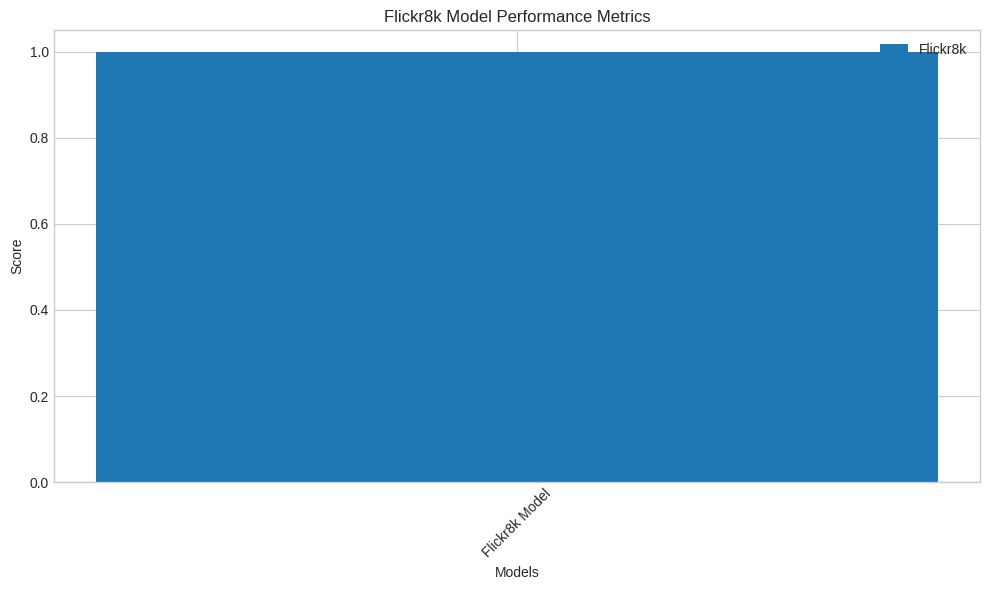

In [ ]:
visualizer.plot_metric_comparison(
    metrics_dict={'Flickr8k': list(flickr8k_metrics.values())},
    model_names=['Flickr8k Model'],
    title="Flickr8k Model Performance Metrics"
)

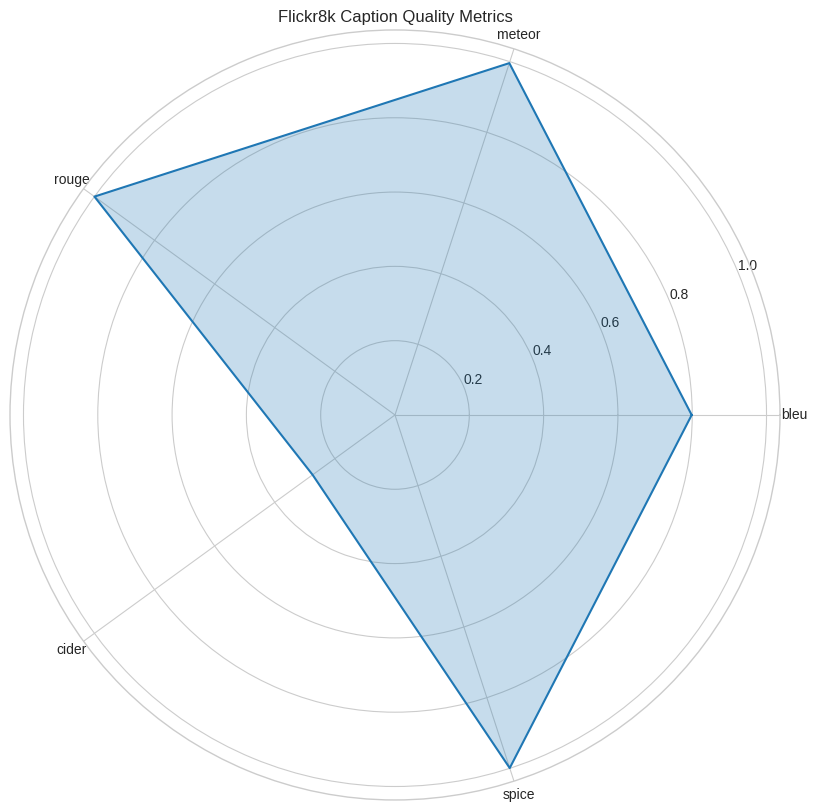

In [ ]:
visualizer.plot_caption_metrics_radar(
    metrics=flickr8k_metrics,
    title="Flickr8k Caption Quality Metrics"
)

In [ ]:
visualizer.plot_caption_length_distribution(
    captions=flickr8k_captions,
    title="Flickr8k Caption Length Distribution"
)

NameError: name 'flickr8k_captions' is not defined

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


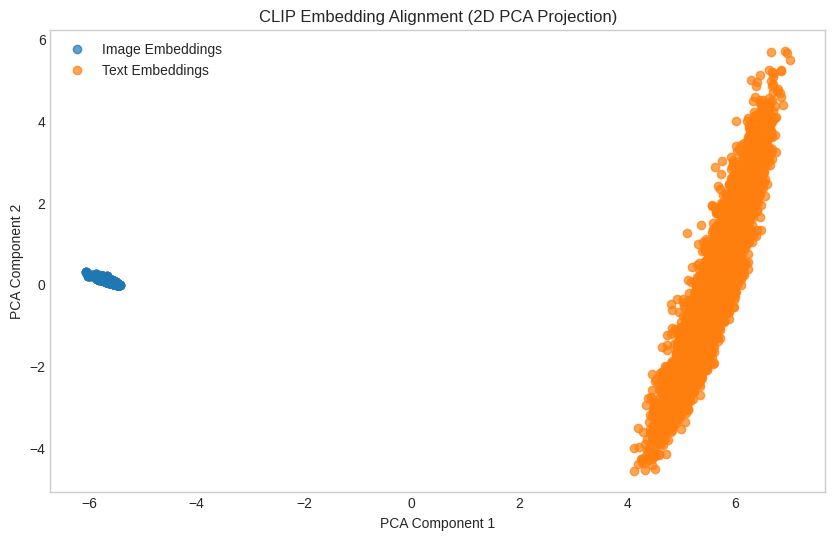

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def plot_clip_embeddings(clip_model, dataloader, processor):
    image_embeddings = []
    text_embeddings = []
    labels = []

    clip_model.eval()
    with torch.no_grad():
        for clip_images, _, captions in dataloader:
            clip_images = clip_images.to(device)
            clip_images = (clip_images - clip_images.min()) / (clip_images.max() - clip_images.min())
            images = processor(images=clip_images, return_tensors="pt").to(device)
            image_features = clip_model.get_image_features(**images)
            image_embeddings.append(image_features.cpu().numpy())

            text_inputs = processor(text=captions, return_tensors="pt", padding=True, truncation=True).to(device)
            text_features = clip_model.get_text_features(**text_inputs)
            text_embeddings.append(text_features.cpu().numpy())

            labels.extend(captions)

    image_embeddings = np.vstack(image_embeddings)
    text_embeddings = np.vstack(text_embeddings)

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(np.vstack((image_embeddings, text_embeddings)))

    reduced_image_embeddings = reduced_embeddings[:len(image_embeddings)]
    reduced_text_embeddings = reduced_embeddings[len(image_embeddings):]

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_image_embeddings[:, 0], reduced_image_embeddings[:, 1], label="Image Embeddings", alpha=0.7)
    plt.scatter(reduced_text_embeddings[:, 0], reduced_text_embeddings[:, 1], label="Text Embeddings", alpha=0.7)
    plt.legend()
    plt.title("CLIP Embedding Alignment (2D PCA Projection)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid()
    plt.show()

plot_clip_embeddings(clip_model, flickr8k_test_loader, clip_processor)
